In [1]:
%matplotlib inline
import os
from argparse import ArgumentParser
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from models.unet.model import *
from helper import *

torch.cuda.set_device(0)

/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akshay/anaconda3/envs/pl/lib/py

In [2]:
class SegModel(pl.LightningModule):
    def __init__(self):
        super(SegModel, self).__init__()
        self.batch_size = 2
        self.learning_rate = 1e-3
#         self.net = torchvision.models.segmentation.fcn_resnet50(pretrained = False, progress = True, num_classes = 19)
        self.net = UNet(num_classes = 19, bilinear = False)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
        ])
        self.trainset = semantic_dataset(split = 'train', transform = self.transform)
        self.testset = semantic_dataset(split = 'test', transform = self.transform)
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_nb) :
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss_val = F.cross_entropy(out, mask, ignore_index = 250)
#         print(loss.shape)
        return {'loss' : loss_val}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 10)
        return [opt], [sch]
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size = self.batch_size, shuffle = True)
    
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size = 1, shuffle = True)

In [3]:
model = SegModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath = 'checkpoints_unet/',
    save_best_only = True,
    verbose = True, 
    monitor = 'loss',
    mode = 'min',
    prefix = ''
)
trainer = pl.Trainer(gpus = 1, max_nb_epochs = 15, checkpoint_callback = checkpoint_callback, early_stop_callback = None)
trainer.fit(model)

/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:188: UserWarning: Checkpoint directory checkpoints_unet/ exists and is not empty with save_best_only=True.All files in this directory will be deleted when a checkpoint is saved!
  f"Checkpoint directory {filepath} exists and is not empty with save_best_only=True."
Epoch 8: 100%|██████████| 100/100 [00:50<00:00,  1.97batch/s, batch_nb=99, gpu=0, loss=0.696, v_nb=11]/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer_io.py:210: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"
Epoch 15: 100%|██████████| 100/100 [00:50<00:00,  1.96batch/s, batch_nb=99, gpu=0, loss=0.646, v_nb=11]


1

In [3]:
model = SegModel()
checkpoint = torch.load('checkpoints_unet/_ckpt_epoch_12.ckpt', map_location = lambda storage, loc : storage)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


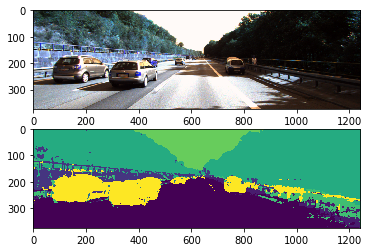

In [7]:
model.cuda()
testloader = model.test_dataloader()
img = next(iter(testloader))
img = img.float().cuda()
y = model.forward(img)
mask_pred = y.cpu().detach().numpy()
mask_pred_bw = np.argmax(mask_pred[0], axis = 0)

unorm = UnNormalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
img2 = unorm(img)
img2 = img.transpose(1, 2).transpose(2, 3).detach().cpu().numpy()

fig, axes = plt.subplots(2, 1)
axes[0].imshow(img2[0])
axes[1].imshow(mask_pred_bw)
plt.savefig('output.png')
plt.show()